# Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re
import string

In [2]:
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

sns.set(font_scale = 2)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Load the DSLD dataframe and explore

In [4]:
# read dataframe
DS_label_df = pd.read_pickle('data/DietarySupplementLabelDatabase.pkl')

DS_label_df.set_index('DSLD_ID', inplace=True)
DS_label_df.head()

,Brand,LanguaL_Dietary_Claim_or_Use,LanguaL_Intended_Target_Groups,LanguaL_Product_Type,LanguaL_Supplement_Form,Product_Name,Serving_Size,ingredients,statements,success
DSLD_ID,,,,,,,,,,
40479,+nuun,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",MULTI-VITAMIN AND MULTI-MINERAL SUPPLEMENT [A1...,TABLET [E0155],+nuun All Day Blueberry Pomegranate,1.0 Tablet(s),"[{'Ingredient_ID': '7388', 'DSLD_Ingredient_Ca...","[{'Statement': 'UNDER 8 CALORIES', 'Statement_...",True
40480,+nuun,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",MULTI-VITAMIN AND MULTI-MINERAL SUPPLEMENT [A1...,TABLET [E0155],+nuun All Day Grape Raspberry,1.0 Tablet(s),"[{'Ingredient_ID': '7388', 'DSLD_Ingredient_Ca...","[{'Statement': 'ALL NATURAL, ZERO SUGAR', 'Sta...",True
40464,+nuun,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",MULTI-VITAMIN AND MULTI-MINERAL SUPPLEMENT [A1...,TABLET [E0155],+nuun All Day Tangerine Lime,1.0 Tablet(s),"[{'Ingredient_ID': '7388', 'DSLD_Ingredient_Ca...",[{'Statement': 'DRINK YOUR VITAMINS + A B C D...,True
40438,+nuun,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",BOTANICAL SUPPLEMENT WITH VITAMIN/MINERAL [A1317],TABLET [E0155],+nuun Natural Hydration Goji Berry Green Tea,16.0 fl. Oz.Alternate 475.0 mL,"[{'Ingredient_ID': '7388', 'DSLD_Ingredient_Ca...",[{'Statement': 'Use only if cap seal is unbrok...,True
40456,+nuun,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",BOTANICAL SUPPLEMENT WITH VITAMIN/MINERAL [A1317],TABLET [E0155],+nuun Natural Hydration Tangerine Ginger,1.0 Effervescent Tablet(s),"[{'Ingredient_ID': '7388', 'DSLD_Ingredient_Ca...","[{'Statement': 'by +nuun', 'Statement_Type': '...",True


In [5]:
ingredients_keys = list(
                        pd.DataFrame(list(DS_label_df['ingredients']
                        .apply(pd.Series)
                        .stack()
                        .reset_index(drop=True)))
                        .columns
                      )
print('Unique Ingredients keys:')
pprint(ingredients_keys)

Unique Ingredients keys:
['Amount_Per_Serving',
 'Amount_Serving_Unit',
 'Ancestry__Number_of_Parents_Row_IDs',
 'Blended_Ingredient_Types',
 "Blends'_Ancestry",
 'DSLD_ID',
 'DSLD_Ingredient_Categories',
 'Dietary_Ingredient_Synonym_Source',
 'Ingredient_Group_GRP_ID',
 'Ingredient_ID',
 'Pct_Daily_Value_per_Serving',
 'Serving_Size',
 'Suggested_Recommended_Usage_Directions:']


In [6]:
statements_keys = list(
                        pd.DataFrame(list(DS_label_df['statements']
                        .apply(pd.Series)
                        .stack()
                        .reset_index(drop=True)))
                        .columns
                      )
print('Unique statements keys:')
pprint(statements_keys)

Unique statements keys:
['DSLD_ID', 'Statement', 'Statement_Type']


# Extract selected keys from the json type columns

## A. Flatten *ingredients* column

In [7]:
def flatten_ingredients(list_of_ingredient_dicts):
    selected_keys = ['Dietary_Ingredient_Synonym_Source', 
                     'DSLD_Ingredient_Categories']
    
    ingredient_     = {}   
    synonym_source_ = set()
    categories_     = set()
    
    for ingredient_dict in list_of_ingredient_dicts:
        if ingredient_dict[selected_keys[0]]:
            synonym_source_.add(ingredient_dict[selected_keys[0]].strip(' ,.'))
        if ingredient_dict[selected_keys[1]]:
            categories_.add(ingredient_dict[selected_keys[1]].strip(' ,.'))

    ingredient_['Ingredient_Count']          = len(list_of_ingredient_dicts)
    ingredient_['Ingredient_Synonym_Source'] = ', '.join(synonym_source_)
    ingredient_['Ingredient_Categories']     = ', '.join(categories_)

    return ingredient_          

In [8]:
ingredients_df = pd.DataFrame(
                             list(DS_label_df['ingredients'].apply(flatten_ingredients)), 
                             index=DS_label_df['ingredients'].index
                            )
print('Dimension of Ingredients DF:', ingredients_df.shape)
ingredients_df.head()

Dimension of Ingredients DF: (65499, 3)


,Ingredient_Categories,Ingredient_Count,Ingredient_Synonym_Source
DSLD_ID,,,
40479,"vitamin, fat, other, carbohydrate, mineral, pr...",23,"Vitamin B6 (as Pyridoxine HCl), Riboflavin ..."
40480,"vitamin, fat, other, carbohydrate, mineral, pr...",23,"Vitamin B6 (as Pyridoxine HCl), Riboflavin ..."
40464,"vitamin, fat, other, carbohydrate, mineral, pr...",23,"Vitamin B6 (as Pyridoxine HCl), Riboflavin ..."
40438,"vitamin, fat, carbohydrate, mineral, botanical...",20,"Riboflavin, Vitamin C (Ascorbic Acid), Fat, T..."
40456,"vitamin, fat, carbohydrate, mineral, botanical...",20,"Riboflavin, Vitamin C (Ascorbic Acid), Fat, T..."


## B. Flatten *statements* column

In [9]:
# get all the statement types across all the supplements
statement_types = list(
                        pd.DataFrame(list(DS_label_df['statements']
                        .apply(pd.Series)
                        .stack()
                        .reset_index(drop=True)))
                        ['Statement_Type']
                        .unique()
                      )
print('All Statement Types:')
pprint(statement_types)

All Statement Types:
['Other',
 'Seals/Symbols',
 'Formulation',
 'Product Specific Information',
 'Precautions',
 None,
 'Suggested/Recommended/Usage/Directions',
 'FDA Disclaimer Statement',
 'Brand Intellectual Property (IP) Statement Information',
 'FDA Statement of Identity']


In [10]:
def flatten_statements(list_of_statement_dicts):
    selected_types = ['Other', 'Seals/Symbols', 'Formulation', 'Product Specific Information', 
                      'Suggested/Recommended/Usage/Directions', 'FDA Statement of Identity', 
                      'Brand Intellectual Property (IP) Statement Information']
    
    statement_        = {}
    precautions_      = set()
    other_statements_ = set()
    
    statement_['Has_FDA_Disclaimer'] = False
    
    for statement_dict in list_of_statement_dicts:
        if statement_dict['Statement_Type']=='Precautions':
            if statement_dict['Statement']:
                precautions_.add(statement_dict['Statement'])
            
        elif statement_dict['Statement_Type'] in selected_types:
            if statement_dict['Statement']:
                other_statements_.add(statement_dict['Statement'])
            
        elif statement_dict['Statement_Type'] =='FDA Disclaimer Statement':
            statement_['Has_FDA_Disclaimer'] = True
    
    statement_['Precautions']        = ', '.join(precautions_)
    statement_['Other_Statements']   = ', '.join(other_statements_)
        
    return statement_          

In [11]:
statements_df = pd.DataFrame(
                             list(DS_label_df['statements'].apply(flatten_statements)), 
                             index=DS_label_df['statements'].index
                            )
print('Dimension of Statements DF:', statements_df.shape)
statements_df.head()

Dimension of Statements DF: (65499, 3)


,Has_FDA_Disclaimer,Other_Statements,Precautions
DSLD_ID,,,
40479,False,"15 tabs inside, REUSE YOUR BOTTLE, DRINK YOUR ...",Use only if cap seal is unbroken
40480,False,"15 tabs inside, REUSE YOUR BOTTLE, DRINK YOUR ...",Use only if cap seal is unbroken
40464,False,"15 tabs inside, REUSE YOUR BOTTLE, {Recycle} 5...",Use only if cap seal is unbroken
40438,False,"your water, your way, {Recycle} 5 PP, store be...",Use only if cap seal is unbroken
40456,False,"your water, your way, from the people at +nuun...",Use only if cap seal is unbroken


## C. Merge with original Dataframe

In [12]:
DS_label_df = pd.concat(
                        [ DS_label_df.drop(['statements', 'ingredients'], axis=1), 
                          ingredients_df, 
                          statements_df], 
                        axis=1
                       ).copy()
DS_label_df.sample(5)

,Brand,LanguaL_Dietary_Claim_or_Use,LanguaL_Intended_Target_Groups,LanguaL_Product_Type,LanguaL_Supplement_Form,Product_Name,Serving_Size,success,Ingredient_Categories,Ingredient_Count,Ingredient_Synonym_Source,Has_FDA_Disclaimer,Other_Statements,Precautions
DSLD_ID,,,,,,,,,,,,,,
1987,Natural Guardian,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]","DIETARY SUPPLEMENT, MINERAL [A1299]","LIQUID, SUPPLEMENT FORM [E0165]",Natural Guardian AG 200 Colloidal Silver,1.0 oz. [30 mL]Alternate 30.0 mL [1 oz],True,"fat, mineral, header",3,"Calories, Calories from Fat, Colloidal Silver",True,"It Is Sold As A Dietary Supplement Only., AG 2...",
11094,21st Century,NUTRITION-RELATED CLAIM OR USE [P0065]; OTHER ...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]",SINGLE VITAMIN AND SINGLE MINERAL SUPPLEMENT [...,TABLET [E0155],21st Century Oyster Shell Calcium 250 +D,2.0 Tablet(s),True,"mineral, vitamin",2,"Vitamin D3 (Cholecalciferol), Calcium (from...",True,"D3, Unconditionally guaranteed for purity, fre...","Keep out of reach of children., Do not use if ..."
4529,Nature's Sunshine,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]","DIETARY SUPPLEMENT, HERBAL OR BOTANICAL [A1306]",CAPSULE [E0159],Nature's Sunshine Kudzu/St. John's Wort,1.0 Capsule(s),True,"blend, botanical",4,"Alfalfa (Medicago sativa) (aerial parts), Pro...",False,There is evidence that links diadzin to the po...,WARNING: Do not use this product while taking ...
36032,NOW,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]","DIETARY SUPPLEMENT, OTHER NUTRITIVE SUPPLEMENT...",CAPSULE [E0159],NOW D-Mannose 500 mg,3.0 Veg Capsule(s),True,"carbohydrate, other",4,"D-Mannose (1,500 mg), Total Carbohydrate, Cal...",True,"HEALTHY URINARY TRACT, Vegetarian/Vegan, Store...","Caution: For adults only., Do Not Eat Freshnes..."
14739,CocoaWell,OTHER INGREDIENT- OR CONSTITUENT-RELATED CLAIM...,"HUMAN CONSUMER, FOUR YEARS AND ABOVE [P0250]","DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",POWDER [E0162],CocoaWell Dark Chocolate Energy Powder,1.0 Scoop(s) [15 Gram(s)]Alternate 15.0 Gram...,True,"chemical, fat, carbohydrate, other, mineral, b...",15,"Total Fat, Chocamine Plus(R) Powder (Low-Fat...",True,Our delicious dark chocolate energy powder wit...,PLEASE NOTE: COCOA IS HAZARDOUS TO PETS.


In [13]:
print('Dataframe dimensions:', DS_label_df.shape)
print('Dataframe Columns:')
pprint(list(DS_label_df.columns))

Dataframe dimensions: (65499, 14)
Dataframe Columns:
['Brand',
 'LanguaL_Dietary_Claim_or_Use',
 'LanguaL_Intended_Target_Groups',
 'LanguaL_Product_Type',
 'LanguaL_Supplement_Form',
 'Product_Name',
 'Serving_Size',
 'success',
 'Ingredient_Categories',
 'Ingredient_Count',
 'Ingredient_Synonym_Source',
 'Has_FDA_Disclaimer',
 'Other_Statements',
 'Precautions']


# Check LanguaL features

In [14]:
def get_LanguaL_codes(claims_):
    pattern_ = re.compile('\[(P\d+)\]')
    codes_ = []
    if claims_:
        codes_ = set(pattern_.findall(claims_))
    return list(codes_)

## A. Check *LanguaL_Dietary_Claim_or_Use*

In [15]:
DS_label_df.loc[:,'LanguaL_Dietary_Claim_or_Use'] = (DS_label_df['LanguaL_Dietary_Claim_or_Use']
                                                     .apply(get_LanguaL_codes))

unique_claim_codes = set(
                          [item 
                           for sublist in list(DS_label_df['LanguaL_Dietary_Claim_or_Use']) 
                           for item in sublist]
                     )
print('Unique LanguaL Dietary Claim or Use Codes:', unique_claim_codes)

Unique LanguaL Dietary Claim or Use Codes: {'P0124', 'P0265', 'P0115', 'P0065', 'P0276', 'P0264'}


## B. Check *LanguaL_Intended_Target_Groups*

In [16]:
DS_label_df.loc[:,'LanguaL_Intended_Target_Groups'] = (DS_label_df['LanguaL_Intended_Target_Groups']
                                                       .apply(get_LanguaL_codes))

unique_target_codes = set(
                          [item 
                           for sublist in list(DS_label_df['LanguaL_Intended_Target_Groups']) 
                           for item in sublist]
                         )
print('Unique LanguaL Intended Target Groups Codes:', unique_target_codes)

Unique LanguaL Intended Target Groups Codes: {'P0250', 'P0192', 'P0266', 'P0253'}


## C. Check *LanguaL_Product_Type*

In [17]:
print('Unique LanguaL Product Type:\n', DS_label_df['LanguaL_Product_Type'].unique())

Unique LanguaL Product Type:
 ['MULTI-VITAMIN AND MULTI-MINERAL SUPPLEMENT [A1315]'
 'BOTANICAL SUPPLEMENT WITH VITAMIN/MINERAL [A1317]'
 'DIETARY SUPPLEMENT, AMINO ACID OR PROTEIN [A1305]'
 'DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]'
 'FATTY ACID OR FAT/OIL SUPPLEMENT [A1310]'
 'DIETARY SUPPLEMENT, HERBAL OR BOTANICAL [A1306]'
 'DIETARY SUPPLEMENT, NON-NUTRIENT/NON-BOTANICAL SUPPLEMENT [A1309]'
 'DIETARY SUPPLEMENT, MINERAL [A1299]'
 'SINGLE VITAMIN AND SINGLE MINERAL SUPPLEMENT [A1316]'
 'DIETARY SUPPLEMENT, VITAMIN [A1302]'
 'DIETARY SUPPLEMENT, OTHER NUTRITIVE SUPPLEMENT [A1326]']


## D. Check *LanguaL_Supplement_Form*

In [18]:
print('Unique LanguaL Supplement Form:\n', DS_label_df['LanguaL_Supplement_Form'].unique())

Unique LanguaL Supplement Form:
 ['TABLET [E0155]' 'POWDER [E0162]' 'CAPSULE [E0159]'
 'SOFTGEL CAPSULE [E0161]' 'LIQUID, SUPPLEMENT FORM [E0165]'
 'SUPPLEMENT FORM, OTHER [E0172]' 'SUPPLEMENT FORM, UNKNOWN [E0177]'
 'GUMMY [E0176]' 'BAR [E0164]' 'LOZENGE [E0174]']


# Memory Optimization (change dtypes)

In [19]:
# Function to compute the memory usage of a dataframe
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [20]:
print('Dataframe dimensions:', DS_label_df.shape)
print('Dataframe Columns:')
pprint(list(DS_label_df.columns))

Dataframe dimensions: (65499, 14)
Dataframe Columns:
['Brand',
 'LanguaL_Dietary_Claim_or_Use',
 'LanguaL_Intended_Target_Groups',
 'LanguaL_Product_Type',
 'LanguaL_Supplement_Form',
 'Product_Name',
 'Serving_Size',
 'success',
 'Ingredient_Categories',
 'Ingredient_Count',
 'Ingredient_Synonym_Source',
 'Has_FDA_Disclaimer',
 'Other_Statements',
 'Precautions']


In [21]:
DS_label_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65499 entries, 40479 to 16171
Data columns (total 14 columns):
Brand                             65499 non-null object
LanguaL_Dietary_Claim_or_Use      65499 non-null object
LanguaL_Intended_Target_Groups    65499 non-null object
LanguaL_Product_Type              65499 non-null object
LanguaL_Supplement_Form           65499 non-null object
Product_Name                      65499 non-null object
Serving_Size                      65499 non-null object
success                           65499 non-null bool
Ingredient_Categories             65499 non-null object
Ingredient_Count                  65499 non-null int64
Ingredient_Synonym_Source         65499 non-null object
Has_FDA_Disclaimer                65499 non-null bool
Other_Statements                  65499 non-null object
Precautions                       65499 non-null object
dtypes: bool(2), int64(1), object(11)
memory usage: 6.6+ MB


In [22]:
print('DSLD Dataframe memory usage: {}'
      .format(mem_usage(DS_label_df)))

DSLD Dataframe memory usage: 156.27 MB


In [23]:
DS_label_opt_df = DS_label_df.copy()

In [24]:
# convert int columns to unsigned
df_int = DS_label_df.select_dtypes(include=['int']).copy()

if list(df_int.columns.values):
    df_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    DS_label_opt_df[df_int.columns] = df_int

In [25]:
category_features = ['Brand', 'LanguaL_Product_Type', 'LanguaL_Supplement_Form']
df_obj = DS_label_df[category_features].copy()

if list(df_obj.columns.values):
    df_obj = df_obj.apply(pd.Series.astype, dtype='category')
    DS_label_opt_df[df_obj.columns] = df_obj

In [26]:
print('Optimized DSLD Dataframe memory usage: {}'
      .format(mem_usage(DS_label_opt_df)))

Optimized DSLD Dataframe memory usage: 140.73 MB


In [27]:
DS_label_opt_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65499 entries, 40479 to 16171
Data columns (total 14 columns):
Brand                             65499 non-null category
LanguaL_Dietary_Claim_or_Use      65499 non-null object
LanguaL_Intended_Target_Groups    65499 non-null object
LanguaL_Product_Type              65499 non-null category
LanguaL_Supplement_Form           65499 non-null category
Product_Name                      65499 non-null object
Serving_Size                      65499 non-null object
success                           65499 non-null bool
Ingredient_Categories             65499 non-null object
Ingredient_Count                  65499 non-null uint16
Ingredient_Synonym_Source         65499 non-null object
Has_FDA_Disclaimer                65499 non-null bool
Other_Statements                  65499 non-null object
Precautions                       65499 non-null object
dtypes: bool(2), category(3), object(8), uint16(1)
memory usage: 5.1+ MB


# Preprocessing *Precautions* Column

### Text preparation pipeline
1. Split into tokens.
2. Convert to lowercase.
3. Remove punctuation from each token.
4. Filter out remaining tokens that are not alphanumeric.
5. Filter out tokens that are stop words.

In [28]:
def text_tokenizer(text, tokenize_method='regex'):

    # convert to lower case
    text = text.lower()
    
    # split into words    
    if tokenize_method=='word':
        tokens = word_tokenize(text)
    elif tokenize_method=='regex':
        tokenizer = RegexpTokenizer(',|\s+', gaps=True)
        tokens = tokenizer.tokenize(text)
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # keep tokens that are greater than 2 characters long
    words = [word for word in words if len(word)>2]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    return words

## Get the MedDRA side effects terms

In [29]:
# Read MedDRA side effects
meddra_se_df = pd.read_csv('data/meddra_all_se.tsv', sep='\t', header=None,
                           names=['Col1','Col2','UMLS concept id','MedDRA concept type',
                                  'UMLS_MedDRA','side_effect_name'])

print('MedDRA Dimensions:', meddra_se_df.shape)
meddra_se_df.head()

MedDRA Dimensions: (309849, 6)


,Col1,Col2,UMLS concept id,MedDRA concept type,UMLS_MedDRA,side_effect_name
0,CID100000085,CID000010917,C0000729,LLT,C0000729,Abdominal cramps
1,CID100000085,CID000010917,C0000729,PT,C0000737,Abdominal pain
2,CID100000085,CID000010917,C0000737,LLT,C0000737,Abdominal pain
3,CID100000085,CID000010917,C0000737,PT,C0687713,Gastrointestinal pain
4,CID100000085,CID000010917,C0000737,PT,C0000737,Abdominal pain


In [30]:
# get unique MedDRA side effects
print('Number of unique side effects: {}'.format(meddra_se_df['side_effect_name'].nunique()))
meddra_se_tokens_list = [text_tokenizer(se_name) for se_name in meddra_se_df['side_effect_name'].unique()]
print('Number of tokenized side effect names:', len(meddra_se_tokens_list))

Number of unique side effects: 6123
Number of tokenized side effect names: 6123


## Clean the Precautions Statements

In [31]:
# considering only the precautions
statement_columns = ['Precautions']
DSL_statements_df = pd.DataFrame('', index=DS_label_opt_df.index, columns=['text', 'tokens'])

DSL_statements_df['text']   = DS_label_opt_df[statement_columns]
DSL_statements_df['tokens'] = DSL_statements_df['text'].apply(text_tokenizer)
DSL_statements_df.head()

,text,tokens
DSLD_ID,,
40479,Use only if cap seal is unbroken,"[use, cap, seal, unbroken]"
40480,Use only if cap seal is unbroken,"[use, cap, seal, unbroken]"
40464,Use only if cap seal is unbroken,"[use, cap, seal, unbroken]"
40438,Use only if cap seal is unbroken,"[use, cap, seal, unbroken]"
40456,Use only if cap seal is unbroken,"[use, cap, seal, unbroken]"


## Find MedDRA terms in DS label statements

In [32]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item)>0]

def filter_meddra_se(statement):
    all_se_tokens = [['_'.join(se_tokens)] for se_tokens in meddra_se_tokens_list 
                     if set(se_tokens).intersection(set(statement))==set(se_tokens)]
    all_se_tokens = flatten(all_se_tokens)
    if all_se_tokens:
        return all_se_tokens
    else:
        return None

In [33]:
# filter the MedDRA terms
DSL_statements_df['MedDRA_SE'] = DSL_statements_df['tokens'].apply(filter_meddra_se)
DSL_statements_df['MedDRA_SE'].head()

DSLD_ID
40479    None
40480    None
40464    None
40438    None
40456    None
Name: MedDRA_SE, dtype: object

## Filter rows with no side effect terms

In [34]:
DS_label_opt_df['MedDRA_SE'] = DSL_statements_df['MedDRA_SE'].copy()

DS_label_select_df = DS_label_opt_df[DS_label_opt_df['MedDRA_SE'].notnull()].copy()

DS_label_select_df['MedDRA_SE_text'] = DS_label_select_df['MedDRA_SE']\
                                       .apply(lambda x: ' '.join(x))

print('Number of selected dietary supplements:', DS_label_select_df.shape)
DS_label_select_df.sample(5)

Number of selected dietary supplements: (16966, 16)


,Brand,LanguaL_Dietary_Claim_or_Use,LanguaL_Intended_Target_Groups,LanguaL_Product_Type,LanguaL_Supplement_Form,Product_Name,Serving_Size,success,Ingredient_Categories,Ingredient_Count,Ingredient_Synonym_Source,Has_FDA_Disclaimer,Other_Statements,Precautions,MedDRA_SE,MedDRA_SE_text
DSLD_ID,,,,,,,,,,,,,,,,
63937,GNC Herbal Plus,"[P0265, P0115]",[P0250],"DIETARY SUPPLEMENT, HERBAL OR BOTANICAL [A1306]",CAPSULE [E0159],GNC Herbal Plus Panax Gisneng 600 mg,1.0 Capsule(s),True,botanical,1,Panax ginseng root extract (Panax ginseng) (r...,True,"Herbal supplement, Directions: As a dietary su...",Warning: Consult your physician prior to using...,[surgery],surgery
6582,MuscleTech,"[P0265, P0115, P0065]",[P0250],"DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",POWDER [E0162],MuscleTech Nitro-Tech Hardcore Pro Series Choc...,1.0 Scoop(s) [33g]Alternate 33.0 g [1 Scoop],True,"fiber, vitamin, chemical, fat, carbohydrate, m...",59,"Calcium, L-Proline, Taurine, Vitamin B6 (as ...",True,MULTIMILLION-DOLLAR RESEARCH BUDGET\nA portion...,NOTICE: USE THIS PRODUCT AS A FOOD SUPPLEMENT ...,"[chest_pain, rash, pain, vomiting, asthma, myo...",chest_pain rash pain vomiting asthma myocardia...
78468,GNC Pro Performance,"[P0265, P0115]",[P0250],"DIETARY SUPPLEMENT, NON-NUTRIENT/NON-BOTANICAL...",POWDER [E0162],GNC Pro Performance Creatine Monohydrate Unfla...,1.0 Rounded Teaspoon(s) [5 g]Alternate 5.0 G...,True,chemical,1,Creatine Monohydrate,True,"5000 mg Creatine Monohydrate, Banned substance...",Warning: Consult your physician prior to using...,[surgery],surgery
69268,Country Life,"[P0265, P0115, P0065]",[P0250],"DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",CAPSULE [E0159],Country Life Essential Life Capsules,4.0 Capsule(s),True,"vitamin, chemical, carbohydrate, other, minera...",42,"Horsetail extract 2:1 (leaf/stem), Bromelain ...",True,"With 500 mg of immune supporting Vitamin C, Co...","Children, pregnant women, and women who might ...","[diabetic, surgery, poisoning, overdose, accid...",diabetic surgery poisoning overdose accidental...
42327,GNC Pro Performance AMP,"[P0265, P0115, P0065]",[P0250],"DIETARY SUPPLEMENT, NON-NUTRIENT/NON-BOTANICAL...","SUPPLEMENT FORM, OTHER [E0172]",GNC Pro Performance AMP Mega Men Powered Stren...,2.0 White Caplet(s),True,other,1,PEG-Creatine System (Creatine Hydrochloride),True,ADVANCED SPORTS VITAMIN SYSTEM TO ENHANCE STRE...,"KEEP OUT OF REACH OF CHILDREN., WARNING: Consu...",[surgery],surgery


## Check the frequency of the side effect terms

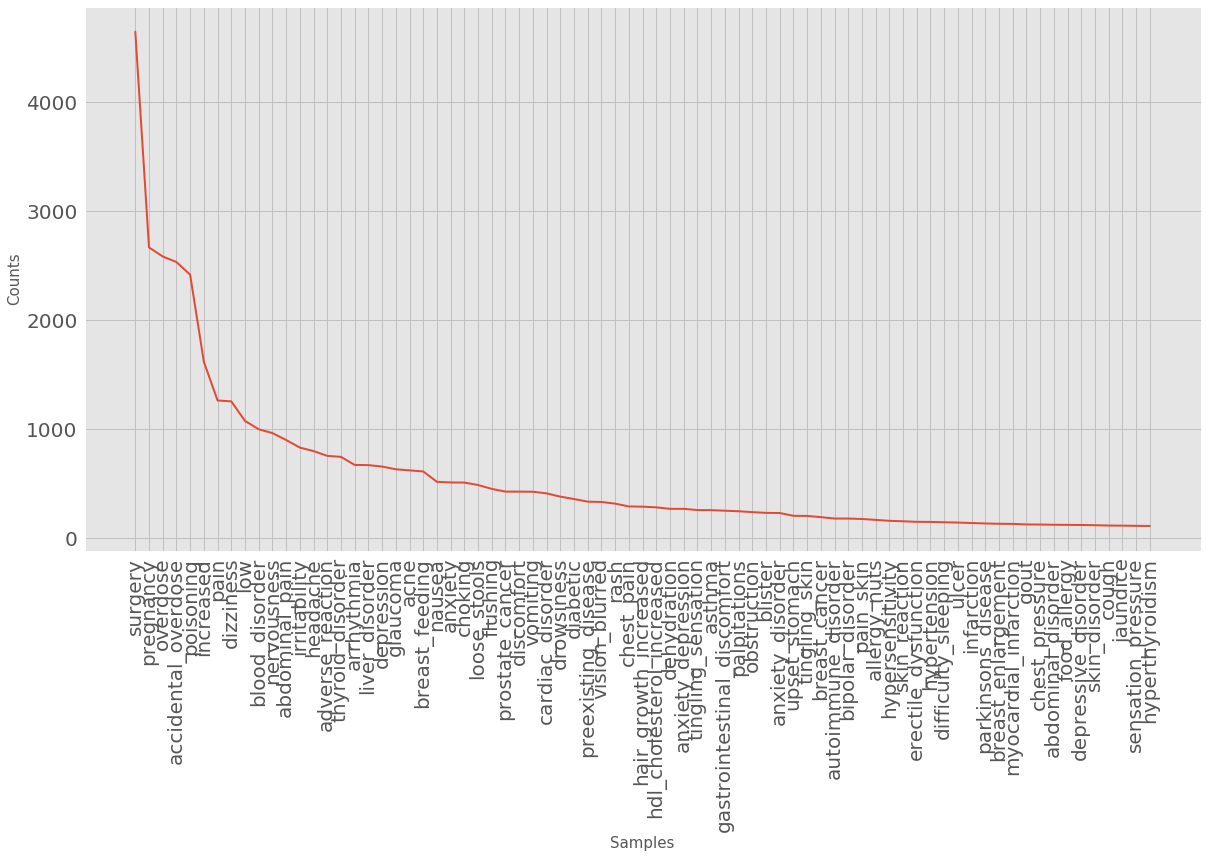

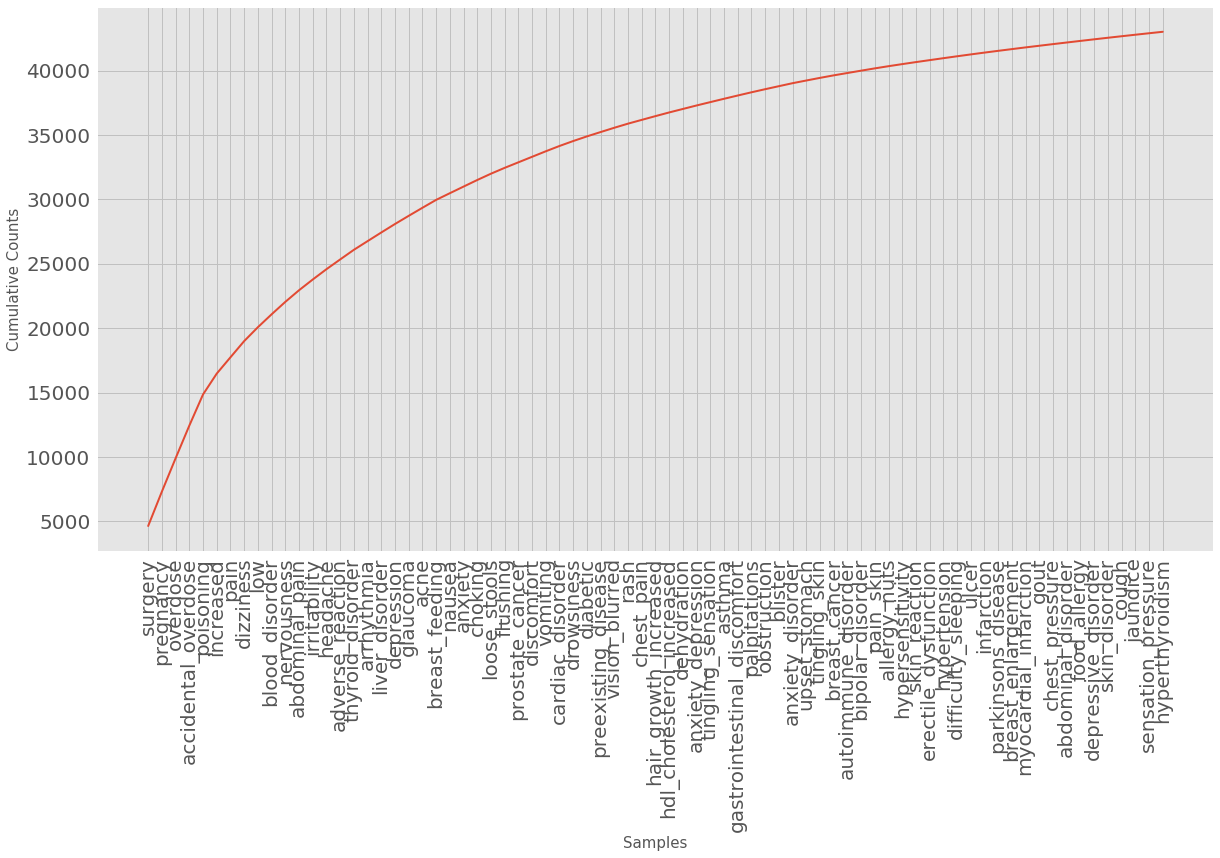

[('surgery', 4647),
 ('pregnancy', 2669),
 ('overdose', 2586),
 ('accidental_overdose', 2535),
 ('poisoning', 2419),
 ('increased', 1620),
 ('pain', 1265),
 ('dizziness', 1257),
 ('low', 1078),
 ('blood_disorder', 1001),
 ('nervousness', 966),
 ('abdominal_pain', 903),
 ('irritability', 833),
 ('headache', 801),
 ('adverse_reaction', 757)]


In [35]:
fd = nltk.FreqDist([elem for row in DS_label_select_df['MedDRA_SE'] for elem in row])

plt.figure(figsize=(20, 10))
fd.plot(75)

plt.figure(figsize=(20, 10))
fd.plot(75, cumulative=True)

pprint(fd.most_common(15))

# Pickle the cleaned dataframe

In [ ]:
# write dataframe
DS_label_select_df.to_csv('data/DietarySupplementLabelDatabasePrecautionsFiltered.csv')
DS_label_select_df.to_pickle('data/DietarySupplementLabelDatabasePrecautionsFiltered.pkl')

# Save the side effects vocab

In [36]:
flatten = lambda l: [item.replace('_','~') for sublist in l for item in sublist if len(item)>0]
se_vocab_ = pd.Series(list(flatten(DS_label_select_df['MedDRA_SE'])))
se_vocab_.head()

0    adverse~reaction
1    adverse~reaction
2    adverse~reaction
3    adverse~reaction
4    adverse~reaction
dtype: object

In [ ]:
se_vocab_.to_csv('data/DietarySupplementLabelSideEffectTerms.txt', index=False)